Student Names : Sadra Khanjari, Parham Gilani

Student ID : 400101107, 400101859

## Part 1 : Data Preprocessing

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from torchvision.utils import make_grid
import torchvision
import matplotlib.animation as animation

Here we wrote a transfrom function that convert the data into a binary format.

In [4]:
class BinarizeTransform:
    def __init__(self, threshold=127):
        self.threshold = threshold / 255 

    def __call__(self, img):
        img_np = np.array(img)
        return torch.tensor((img_np > self.threshold).astype(np.float32))

In this section we show the first 10 numbers in the dataset and the corresponding binary format.

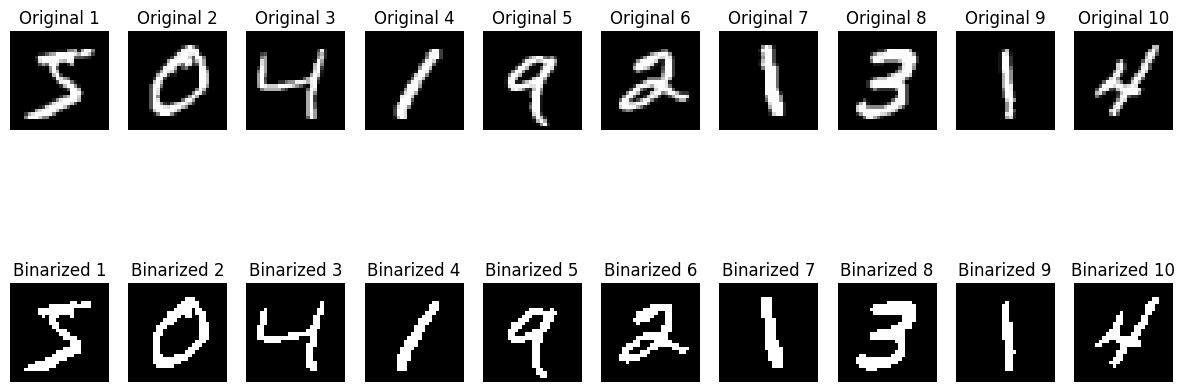

(64, 28, 28)


In [5]:
# Load the MNIST dataset
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size
)


# Create a new loader with the binarization transform
transform = transforms.Compose([
    transforms.ToTensor(),         
    BinarizeTransform(threshold=127)  
])
binarized_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=False, transform=transform),
    batch_size=batch_size  # Set batch_size to 10
)

# Display the first 10 images from the original and binarized loaders
images, labels = next(iter(train_loader))
images_np = images.numpy().squeeze()

binarized_images , _ = next(iter(binarized_loader))
binarized_images = binarized_images.numpy().squeeze()

fig, axes = plt.subplots(2, 10, figsize=(15, 6))

for i in range(10):
    axes[0, i].imshow(images_np[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")

    axes[1, i].imshow(binarized_images[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Binarized {i+1}")

plt.show()

print(binarized_images.shape)

## Part 2 : Algorithm Implementation and Training

Here we defined the Boltzmann Machine class and the training algorithm.

In [6]:
class RBM(nn.Module):
    """
    Boltzmann Machine class with restricted connectivity.

    """

    def __init__(self, num_visible=784, num_hidden=128, gibbs_steps=1):
        """
        Initialize the Restricted Boltzmann Machine (RBM).
        
        Args:
            num_visible (int): Number of visible units (input features).
            num_hidden (int): Number of hidden units.
            gibbs_steps (int): Number of Gibbs sampling steps.
        """
        super(RBM, self).__init__()
        self.visible_bias = nn.Parameter(torch.randn(1, num_visible))  
        self.hidden_bias = nn.Parameter(torch.randn(1, num_hidden)) 
        self.weights = nn.Parameter(torch.randn(num_hidden, num_visible))
        self.gibbs_steps = gibbs_steps 
        self.generated_samples = []

    def visible_to_hidden(self, visible_units):
        """
        Sample hidden units conditionally given visible units.

        Args:
            visible_units (Tensor): The visible units (input data).

        Returns:
            Tensor: The sampled hidden units.
        """
        hidden_probabilities = torch.sigmoid(F.linear(visible_units, self.weights, self.hidden_bias))
        return hidden_probabilities.bernoulli()

    def hidden_to_visible(self, hidden_units):
        """
        Sample visible units conditionally given hidden units.

        Args:
            hidden_units (Tensor): The hidden units.

        Returns:
            Tensor: The sampled visible units.
        """
        visible_probabilities = torch.sigmoid(F.linear(hidden_units, self.weights.t(), self.visible_bias))
        return visible_probabilities.bernoulli()

    def free_energy(self, visible_units):
        """
        Compute the free energy of the visible units.

        Args:
            visible_units (Tensor): The visible units (input data).

        Returns:
            FloatTensor: The computed free energy.
        """
        visible_term = torch.matmul(visible_units, self.visible_bias.t())
        hidden_activation = F.linear(visible_units, self.weights, self.hidden_bias)
        hidden_term = torch.sum(F.softplus(hidden_activation), dim=1)
        return torch.mean(-hidden_term - visible_term)

    def forward(self, visible_units):
        """
        Perform Gibbs sampling to generate reconstructed visible units.

        Args:
            visible_units (Tensor): The visible units (input data).

        Returns:
            (Tensor, Tensor): The original visible units and the generated visible units after Gibbs sampling.
        """
        hidden_units = self.visible_to_hidden(visible_units) 
        for _ in range(self.gibbs_steps):
            generated_visible = self.hidden_to_visible(hidden_units)
            self.generated_samples.append(generated_visible)
            hidden_units = self.visible_to_hidden(generated_visible)
        return visible_units, generated_visible
    
    def get_generated_samples(self):
        return self.generated_samples


In [7]:
def train(model, train_loader, n_epochs=20, lr=0.01):
    """
    Train the Restricted Boltzmann Machine (RBM) model.

    Args:
        model (BoltzmannMachine): The RBM model to train.
        train_loader (DataLoader): The training data loader.
        n_epochs (int): The number of training epochs.
        lr (float): The learning rate.
    
    Returns:
        BoltzmannMachine: The trained RBM model.
    """

    # Optimizer
    train_op = optim.Adam(model.parameters(), lr)

    # Train the RBM model
    model.train()

    # Training loop
    for epoch in range(n_epochs):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            v, v_gibbs = model(data.view(-1, 784))
            loss = model.free_energy(v) - model.free_energy(v_gibbs)
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
            

        print(f'Epoch {epoch}/{n_epochs} Loss={np.mean(loss_) :.4f}')

    return model

Here is the function that shows and also saves the results of the training in images.

In [24]:
def show_and_save_image(img, file_name, title=None):
    """
    Function to show and save images.

    Args:
        img (Tensor): The image tensor.
        file_name (str): The file name to save the image.
        title (str, optional): The title of the image. Defaults to None.
    """
    # Convert tensor to numpy
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = f"./Results/{file_name}.png"
    # Show the image
    plt.imshow(npimg, cmap='gray')
    plt.imsave(f, npimg)
    if title:
        plt.title(title)
    plt.axis('off')

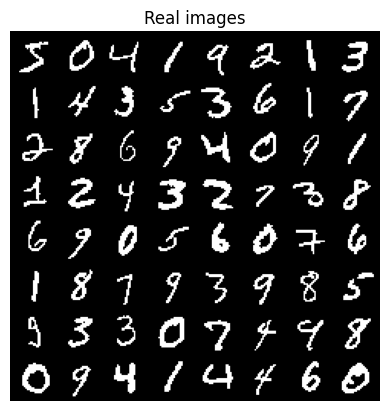

In [25]:
# First 64 images from the binarized pictures
images,labels = next(iter(binarized_loader))
show_and_save_image(make_grid(images), 'Real', title='Real images')

Here we start the training of the Boltzmann Machine with different constrastive divergence steps and also show the results.

Training with k=1
Epoch 0/10 Loss=52.8164
Epoch 1/10 Loss=1.6549
Epoch 2/10 Loss=0.9223
Epoch 3/10 Loss=0.9567
Epoch 4/10 Loss=1.2955
Epoch 5/10 Loss=1.5335
Epoch 6/10 Loss=1.6146
Epoch 7/10 Loss=1.8213
Epoch 8/10 Loss=1.9122
Epoch 9/10 Loss=2.0540
Training complete


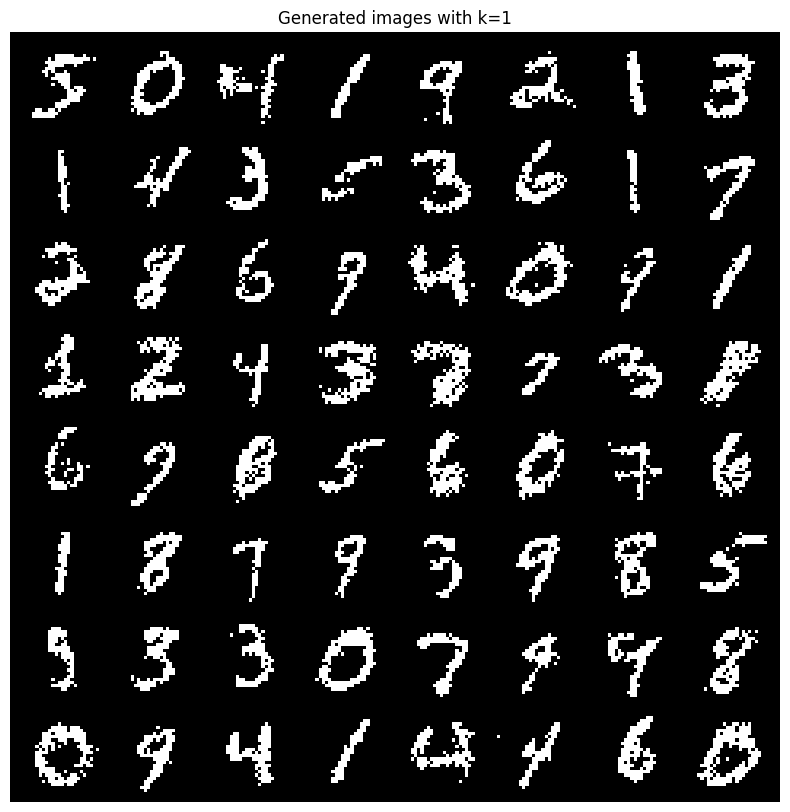

Training with k=5
Epoch 0/10 Loss=70.9093
Epoch 1/10 Loss=4.3040
Epoch 2/10 Loss=2.3004
Epoch 3/10 Loss=2.0875
Epoch 4/10 Loss=2.1104
Epoch 5/10 Loss=2.3157
Epoch 6/10 Loss=2.5465
Epoch 7/10 Loss=2.7625
Epoch 8/10 Loss=2.7071
Epoch 9/10 Loss=2.7221
Training complete


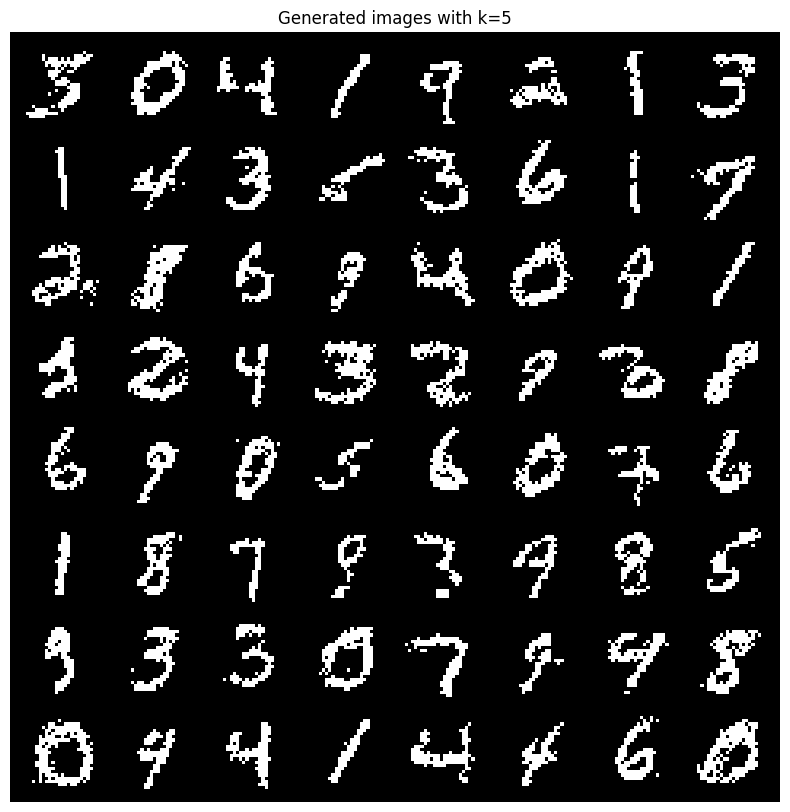

Training with k=10
Epoch 0/10 Loss=66.8523
Epoch 1/10 Loss=3.0802
Epoch 2/10 Loss=2.0739
Epoch 3/10 Loss=2.1917
Epoch 4/10 Loss=2.5429
Epoch 5/10 Loss=2.9127
Epoch 6/10 Loss=2.8988
Epoch 7/10 Loss=3.2057
Epoch 8/10 Loss=3.4315
Epoch 9/10 Loss=3.5940
Training complete


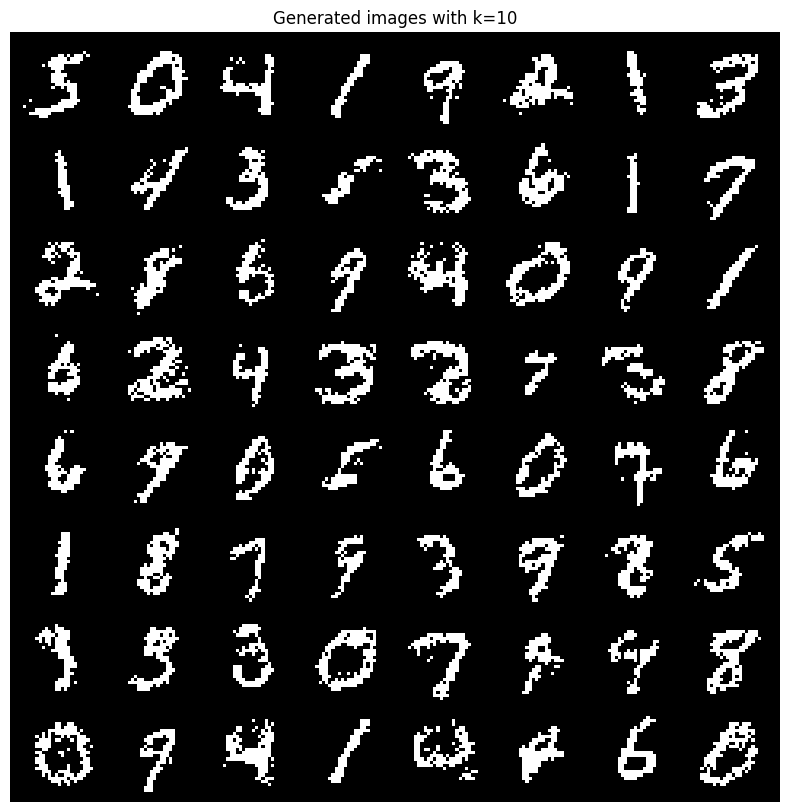

In [136]:
n_epochs = 10

lr = 0.01

n_hidden = 128

n_visible = 784

k_list = [1,5,10]
for k in k_list:
    print(f"Training with k={k}")
    model = RBM(num_visible=n_visible, num_hidden=n_hidden, gibbs_steps=k)
    model = train(model, binarized_loader, n_epochs=n_epochs, lr=lr)
    print("Training complete")
    v, v_gibbs = model(images.view(-1, 784))
    plt.figure(figsize=(10, 10))
    show_and_save_image(make_grid(v_gibbs.view(batch_size, 1, 28, 28).data), f'Generated_{k}', title=f'Generated images with k={k}')
    plt.show()

## Part 3 : Showing sample creations in animation

Here we create an animation that shows the creation of samples by the Boltzmann Machine. if it doesn't show the animation in the notebook, you can see the file in the results folder named "rbm_sample_training.mp4".

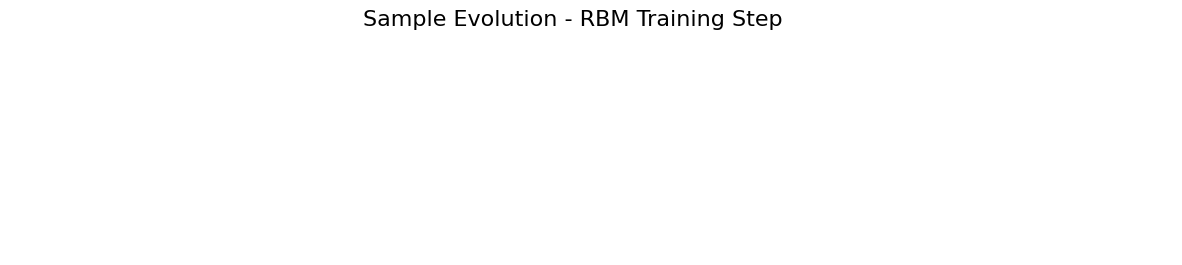

In [158]:
# Initialize the RBM model and training parameters
rbm = RBM(num_visible=784, num_hidden=128, gibbs_steps=1)
train_op = optim.Adam(rbm.parameters(), lr=0.01)
n_samples = 5 

# Fetch a batch of data from binary_loader (assuming batch_size is 64)
for batch_idx, (data, _) in enumerate(binarized_loader):
    if batch_idx == 0:
        break

data = data.view(data.size(0), -1)
generated_data = data[:n_samples]

fig, axes = plt.subplots(1, n_samples, figsize=(15, 3))
fig.suptitle(f"Sample Evolution - RBM Training Step", fontsize=16)
ims = [axes[i].imshow(generated_data[i].detach().cpu().numpy().reshape(28, 28), cmap='binary', animated=True) for i in range(n_samples)]
for ax in axes:
    ax.axis('off')

def init():
    for im in ims:
        im.set_array(np.zeros((28, 28)))
    return ims

# Animation function
def animate(i):
    global generated_data

    #model_input = generated_data.clone().detach() 
    loss_ = []
    for _, (data, target) in enumerate(binarized_loader):
        v, v_gibbs = rbm(data.view(-1, 784))
        loss = rbm.free_energy(v) - rbm.free_energy(v_gibbs)
        loss_.append(loss.item())
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        #print(v_gibbs.shape)
        #print(loss)
        #generated_data = v_gibbs
        generated_data = v_gibbs.detach() 

        break

    for idx, im in enumerate(ims):
        im.set_array(generated_data[idx].detach().cpu().numpy().reshape(28, 28)) 
    return ims

# Create the animation
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=1000,  # Number of frames (iterations)
    interval=200,  # 200 ms delay between frames
    blit=True
)

# Show the animation
plt.show()

# Save the animation as a video
anim.save('./Results/rbm_samples_training.mp4', writer='ffmpeg', fps=10)
# You can see the animation in the Results folder as rbm_samples_training.mp4

## Part 4 : Control on the generated samples

By increasing both the number of epochs and Gibbs steps, we can improve the model's ability to generate controlled samples of specific digits, such as 0 or 1. More epochs provide additional opportunities for the model to learn from the training data, which helps it better capture the essential features of the digit being modeled. As the number of epochs increases, the model will have more time to adjust its weights and biases, which will lead to more accurate approximations of the digit.

On the other hand, increasing the Gibbs steps allows the model to refine its sampling process. With each additional Gibbs step, the model performs more iterations of sampling and refining the visible units, which helps in improving the quality of generated samples. This is particularly important for capturing subtle details in the digit, especially when the model is exposed to complex patterns that may require more steps to approximate correctly.

Together, increasing both epochs and Gibbs steps can lead to better solutions, as the model is given more opportunities to learn the features of the digit and refine its output. For example, by training the model on the digit 0 over many epochs and refining the samples over multiple Gibbs steps, we can achieve a better approximation of the digit 0, improving the model's ability to generate realistic samples of that digit. Similarly, the model will learn to generate controlled samples of specific digits by conditioning it on the desired digit label during both training and inference.

However, it's important to note that as we increase the number of epochs and Gibbs steps, the computational cost also increases. We must find a balance between training time and the quality of the generated samples to avoid unnecessary resource consumption.

In [8]:
import torch
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

# Load the MNIST dataset for digit 0
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])

train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

indices = torch.where(train_data.targets == 0)[0]

train_data_zero = Subset(train_data, indices)

train_loader_zero = DataLoader(train_data_zero, batch_size=64, shuffle=True)

# Train the RBM model on digit 0
print("Training RBM on digit 0")
rbm = RBM(num_visible=784, num_hidden=128, gibbs_steps=10)
model = train(rbm, train_loader_zero, n_epochs=20, lr=0.01)
print("Training complete")


Training RBM on digit 0
Epoch 0/20 Loss=466.0366
Epoch 1/20 Loss=112.3431
Epoch 2/20 Loss=67.8530
Epoch 3/20 Loss=46.4829
Epoch 4/20 Loss=33.7256
Epoch 5/20 Loss=24.9762
Epoch 6/20 Loss=18.9303
Epoch 7/20 Loss=14.8713
Epoch 8/20 Loss=11.7377
Epoch 9/20 Loss=9.2600
Epoch 10/20 Loss=7.7502
Epoch 11/20 Loss=6.2069
Epoch 12/20 Loss=5.0442
Epoch 13/20 Loss=4.7767
Epoch 14/20 Loss=3.9370
Epoch 15/20 Loss=3.3505
Epoch 16/20 Loss=2.7691
Epoch 17/20 Loss=2.5412
Epoch 18/20 Loss=2.3649
Epoch 19/20 Loss=1.9646
Training complete


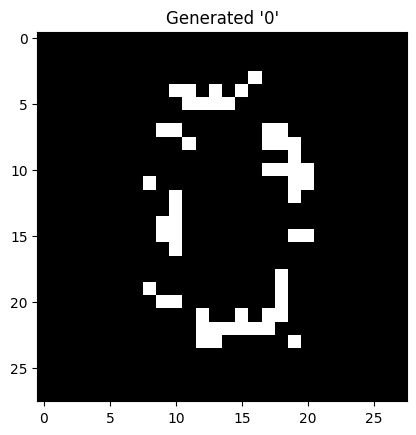

In [22]:
# This is a manually created '0' image, but you can extract from MNIST
zero_image = np.zeros((28, 28))
zero_image_tensor = torch.tensor(zero_image.flatten()).float().view(1, -1)  # Flatten the image

# Perform a forward pass on the model with the '0' image
visible_units, generated_units = model(zero_image_tensor)

# Plot the generated result
generated_image = generated_units.detach().cpu().numpy().reshape(28, 28)
plt.imshow(generated_image, cmap='gray')
plt.title("Generated '0'")
plt.show()